## Подготовка

In [ ]:
# Печатаем длинные строчки https://stackoverflow.com/questions/53482343/how-to-disable-line-wrapping-in-jupyter-notebook-output-cells

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
%%writefile requirements.txt

lightning==2.4.0
torch==2.5.1
spacy==3.7.5
transformers==4.46.2

In [ ]:
!pip install -r requirements.txt

In [ ]:
!python -m spacy download ru_core_news_md

In [ ]:
!rm -rf data
!wget -O data.zip https://github.com/vdobrovolskii/rucoco/releases/download/v1.0.0/v1.0.0.zip
!unzip -q data.zip -d data

In [ ]:
import json
import os

# Убираем расщепленные антецеденты из данных, убираем получившиеся синглтоны
for entry in os.scandir("data"):
    with open(entry, encoding="utf8", mode="r+") as f:
        doc = json.load(f)
        doc["entities"] = [entity for entity in doc["entities"]
                           if len(entity) > 1]
        doc["includes"] = [[] for _ in doc["includes"]]
        f.seek(0)
        json.dump(doc, f)
        f.truncate()


## Данные

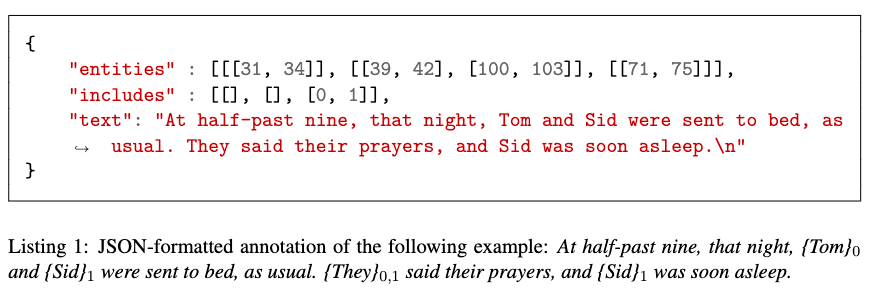

In [ ]:
import json
import os
import random
from typing import *


FILELIST = list(os.scandir("data"))
SPAN_STYLE = "\x1b[31m[{}]\x1b[0m"

In [ ]:
def print_entity(entity: List[Tuple[int, int]], text: str):
    annotated_text = []
    position = max(0, entity[0][0] - 50)
    for start, end in entity:
        annotated_text.append(text[position:start])
        annotated_text.append(SPAN_STYLE.format(text[start:end]))
        position = end
    annotated_text.append(text[position:min(position + 50, len(text))])
    print("".join(annotated_text))

In [ ]:
sample_doc_path = random.choice(FILELIST)

with open(sample_doc_path) as f:
    doc = json.load(f)

entity = random.choice(doc["entities"]) # whoops
print_entity(entity, doc["text"])

### Задание 1, игрушечное
Посчитайте статистику по корпусу:
1. Общее количество слов (за слово считаем подстроку, ограниченную whitespace'ом или началом/концом текста).
2. Общее количество сущностей
3. Общее количество упоминаний
4. Размер самой большой сущности в упоминаниях
5. Средний размер сущности в упоминаниях

In [ ]:
import json
import os


keys = ["total_words", "total_entities", "total_mentions", "max_entity_size", "avg_entity_size"]
stat = {key: 0 for key in keys}

# YOUR CODE GOES HERE

print(*stat.items(), sep="\n")

# quick sanity check
assert int(sum(stat.values()) * 1000) == 1179618287

## Устройство модели*

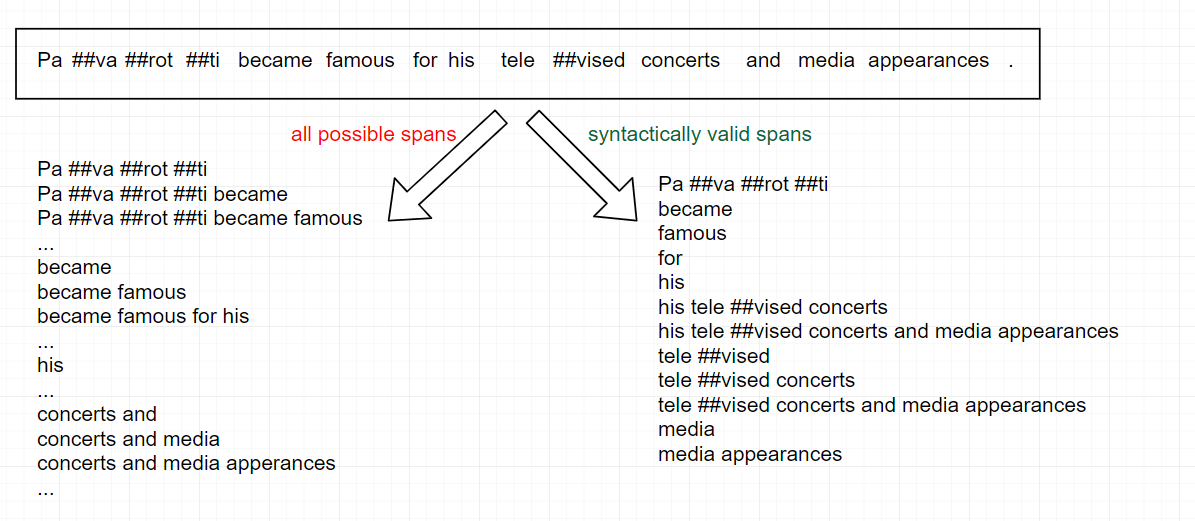

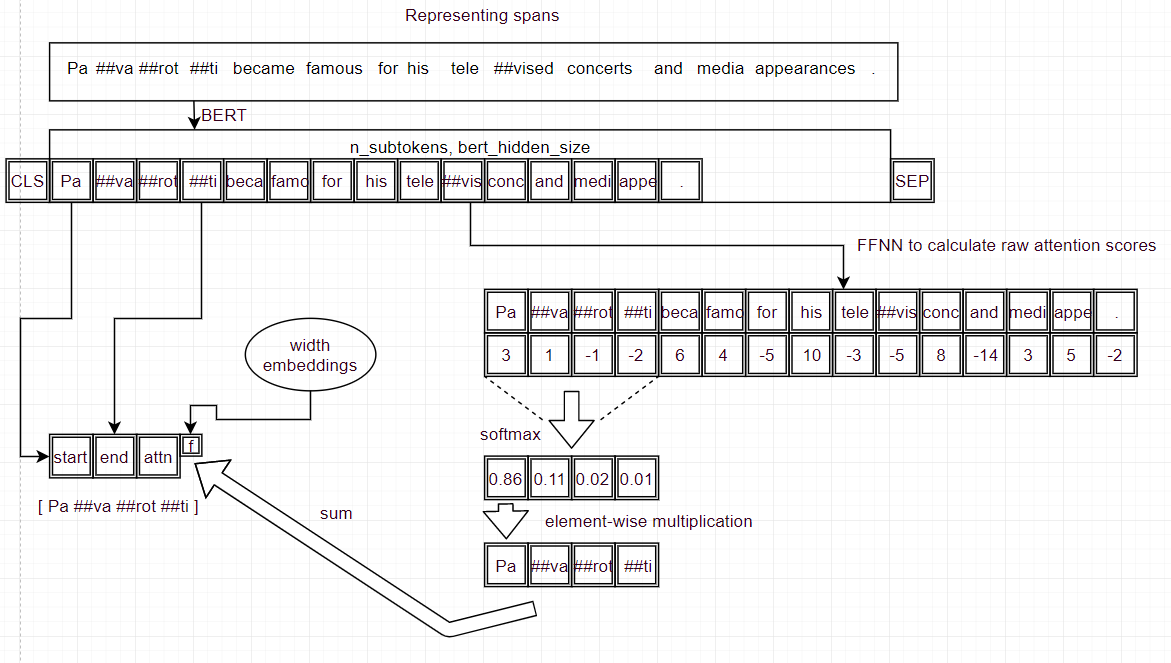

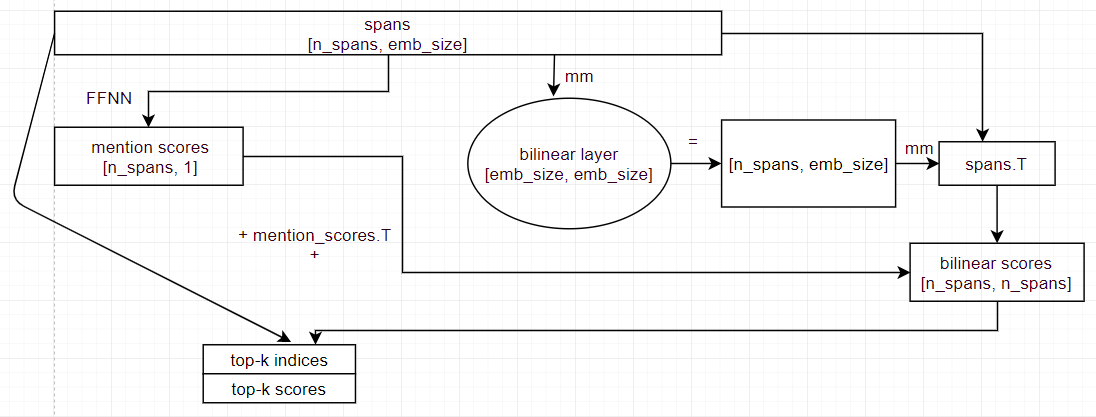

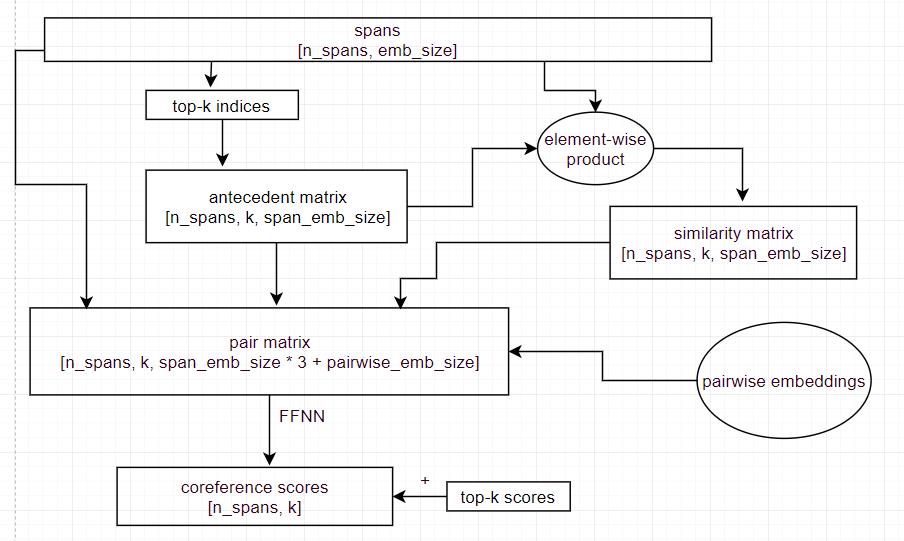

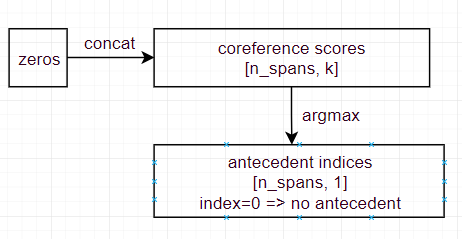

<sub>\* не этой </sub>

## Модель

In [ ]:
import json
import logging
import os
import random
import shutil

import lightning as L
import torch
from tokenizers import pre_tokenizers
from tqdm import tqdm
import transformers
from transformers import AutoModel, AutoTokenizer
import spacy


EPS = 1e-8

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Извлечение упоминаний

In [ ]:
# Извлечение упоминаний, основанное на синтаксическом разборе

class SpanExtractor:
    skipped_pos = {"ADP", "CCONJ", "SCONJ"}
    allowed_punct = {"\"", "'", "(", ")", "."}

    def __init__(self, model_name: str = "ru_core_news_md"):
        self.nlp = spacy.load(model_name)

    def __call__(self, text: str) -> Iterator[Tuple[int, int]]:
        res = self.nlp(text, disable=("lemmatizer", "ner"))
        for token in res:
            if token.pos_ in {"DET", "PRON"}:
                yield token.idx, token.idx + len(token)
            elif token.pos_ in {"NOUN", "PROPN"}:
                start, end = token.idx, token.idx + len(token)
                for i in range(token.i - 1, -1, -1):
                    if (token.sent != res[i].sent
                            or not token.is_ancestor(res[i])):
                        break
                    if res[i].head == token:
                        if self._is_participle_phrase(res[i]):
                            break
                        if self._is_skipped_pos(res[i]):
                            continue
                        leftmost = next(node for node in res[i].subtree if not self._is_skipped_pos(node))
                        if leftmost.idx < start:
                            start = leftmost.idx
                for i in range(token.i + 1, len(res)):
                    if (token.sent != res[i].sent
                            or not token.is_ancestor(res[i])):
                        break
                    if res[i].head == token:
                        if self._is_participle_phrase(res[i]):
                            break
                        if self._is_skipped_pos(res[i]):
                            continue
                        rightmost = next(node for node in reversed(list(res[i].subtree))
                                         if not self._is_skipped_pos(node))
                        if rightmost.idx + len(rightmost) > end:
                            end = rightmost.idx + len(rightmost)
                yield (start, end)

    @staticmethod
    def _is_participle_phrase(token: spacy.tokens.token.Token) -> bool:
        return token.pos_ == "VERB" and any(node != token for node in token.subtree)

    @staticmethod
    def _is_skipped_pos(token: spacy.tokens.token.Token) -> bool:
        return (token.pos_ in SpanExtractor.skipped_pos
            or (token.pos_ == "PUNCT" and token.text not in SpanExtractor.allowed_punct))

### Документ

In [ ]:
# Представление документа для обработки нейроночкой

class Doc:

    span_extractor = SpanExtractor()

    def __init__(self,
                 name: str,
                 data: dict,
                 *,
                 tokenizer: transformers.AutoTokenizer,
                 extract_all_spans: bool = False):
        self.name = name
        self.raw_data = data
        self.encoding = tokenizer(data["text"],
                                  add_special_tokens=True,
                                  padding=True,
                                  truncation=True,
                                  max_length=512,
                                  return_tensors="pt",
                                  return_attention_mask=True,
                                  return_overflowing_tokens=True,
                                  return_offsets_mapping=True,
                                  return_special_tokens_mask=True)
        self.flattening_mask = (self.encoding.special_tokens_mask == 0)
        self.flat_offset_mapping = self.encoding.offset_mapping[self.flattening_mask].tolist()

        self._start_mapping, self._end_mapping = {}, {}
        for token_i, (char_start, char_end) in enumerate(self.flat_offset_mapping):
            if char_start != char_end:
                if char_start in self._start_mapping or char_end in self._end_mapping:
                    continue
                self._start_mapping[char_start] = token_i
                self._end_mapping[char_end] = token_i

        self.entities = self._match_entities_to_tokens()

        self._all_spans = None
        if extract_all_spans:
            self._all_spans = self._extract_all_spans()

    @property
    def all_spans(self) -> Iterator[Tuple[int, int]]:
        """ Returns an iterator over token-level spans """
        if self._all_spans is None:
            self._all_spans = self._extract_all_spans()
        return iter(self._all_spans)

    def char_span_to_tokens(self, span: Tuple[int, int]) -> Optional[Tuple[int, int]]:
        char_start, char_end = span
        token_start = self._start_mapping.get(char_start)
        token_end = self._end_mapping.get(char_end)
        if token_start is not None and token_end is not None:
            return (token_start, token_end + 1)

    def token_span_to_chars(self, span: Tuple[int, int]) -> Tuple[int, int]:
        token_start, token_end = span
        char_start = self.flat_offset_mapping[token_start][0]
        char_end = self.flat_offset_mapping[token_end - 1][1]
        return (char_start, char_end)

    def _extract_all_spans(self) -> List[Tuple[int, int]]:
        out = []
        for char_span in self.span_extractor(self.raw_data["text"]):
            token_span = self.char_span_to_tokens(char_span)
            if token_span:
                out.append(token_span)
        return out

    def _match_entities_to_tokens(self) -> List[List[Tuple[int, int]]]:
        char_entities = self.raw_data["entities"]
        token_entities = []

        for char_entity in char_entities:
            token_entity = []
            for char_start, char_end in char_entity:
                token_span = self.char_span_to_tokens((char_start, char_end))
                if token_span:
                    token_entity.append(token_span)
            if token_entity:
                token_entities.append(token_entity)

        return token_entities

### Модуль PyTorch Lightning

In [ ]:
class LEAResult(NamedTuple):
    precision: float
    precision_weight: float
    recall: float
    recall_weight: float


class CorefModel(L.LightningModule):
    def __init__(self,
                 encoder_model_name: str,
                 *,
                 dropout_rate: float,
                 k: int):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(encoder_model_name)

        ########################################################################
        # # Saving memory
        # for p in self.encoder.parameters():
        #     p.requires_grad = False
        ########################################################################

        self.token_importance_linear = torch.nn.Linear(self.encoder.config.hidden_size, 1)
        self.span_dropout = torch.nn.Dropout(dropout_rate)

        self.coarse_bilinear = torch.nn.Linear(self.encoder.config.hidden_size, self.encoder.config.hidden_size, bias=False)
        self.coarse_dropout = torch.nn.Dropout(dropout_rate)

        self.fine_linear = torch.nn.Sequential(
            torch.nn.Linear(self.encoder.config.hidden_size * 3, self.encoder.config.hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(self.encoder.config.hidden_size, 1)
        )

        self.k = k
        # Validation epoch scores cache
        self.validation_scores = []

    def forward(self, doc: Doc) -> torch.Tensor:

        # Encoding spans

        input_ids, attention_mask = doc.encoding.input_ids.to(self.device), doc.encoding.attention_mask.to(self.device)
        embs = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        embs = embs[doc.flattening_mask]                                                # [n_tokens, emb]

        spans = torch.tensor(list(doc.all_spans), dtype=torch.long, device=self.device) # [n_spans, 2]
        indices = torch.arange(0, len(embs), device=self.device).unsqueeze(0).expand(len(spans), len(embs))  # [n_spans, n_tokens]
        # a binary matrix indicating whether a token belongs to a given span (1 if the token is in the span, 0 otherwise)
        span_mask = (indices >= spans[:, 0].unsqueeze(1)) * (indices < spans[:, 1].unsqueeze(1))
        # log(0) = -inf, log(1) = 0
        span_mask = torch.log(span_mask.to(torch.float))

        token_scores = self.token_importance_linear(embs).squeeze(1)                    # [n_tokens]
        token_scores = token_scores.unsqueeze(0).expand(len(spans), len(embs))          # [n_spans, n_tokens]
        token_scores = torch.softmax(token_scores + span_mask, dim=1)

        embs = token_scores.mm(embs)                                                    # [n_spans, emb]
        embs = self.span_dropout(embs)

        ########################################################################
        # Coarse span pair scoring (по статье 2018 года)

        # Coarse scores are obtained as X * W * X.T, where W is a trainable weight matrix
        # Then the top k antecedents are retrieved

        coref_scores = self.coarse_dropout(self.coarse_bilinear(embs)) @ embs.T
        # Set diagonals one below the main diagonal and higher to -inf, because:
        # A span cannot corefer to itself.
        # A span cannot corefer to a span that appears after it in the document (future spans).
        coref_scores += torch.triu(torch.full_like(coref_scores, -float('inf')), diagonal=-1)
        top_scores, top_indices = torch.topk(coref_scores,
                                             k=min(self.k, len(coref_scores)),
                                             dim=1,
                                             sorted=False)


        # Версия с ближайшими k антецедентами (по статье 2017 года)

        # closest_k = torch.arange(0, len(embs), device=self.device)
        # closest_k = closest_k.unsqueeze(1) - closest_k.unsqueeze(0)
        # closest_k = ((closest_k <= self.k) * (closest_k > 0))
        # closest_k = torch.log(closest_k.to(torch.float))  # 0 for closest ants, -inf otherwise

        # top_scores, top_indices = torch.topk(closest_k,                                 # [n_spans, n_ants]
        #                                      k=min(self.k, len(closest_k)),
        #                                      dim=1, sorted=False)
        ########################################################################

        # Fine span pair scoring
        a_spans = embs.unsqueeze(1).expand(embs.shape[0], top_scores.shape[1], embs.shape[1])
        b_spans = embs[top_indices]
        similarity = a_spans * b_spans
        pair_matrix = torch.cat((a_spans, b_spans, similarity), dim=2)                  # [n_spans, n_ants, pair_emb]

        fine_scores = self.fine_linear(pair_matrix).squeeze(2)                          # [n_spans, n_ants]

        return fine_scores + top_scores, top_indices

    @staticmethod
    def lea(a_clusters: List[List[Tuple[int, int]]],
            b_clusters: List[List[Tuple[int, int]]]) -> LEAResult:
        recall, r_weight = CorefModel._lea(a_clusters, b_clusters)
        precision, p_weight = CorefModel._lea(b_clusters, a_clusters)
        return LEAResult(precision, p_weight, recall, r_weight)

    @staticmethod
    def _lea(key: List[List[Tuple[int, int]]],
            response: List[List[Tuple[int, int]]]) -> Tuple[float, float]:
            """ See aclweb.org/anthology/P16-1060.pdf. """
            response_clusters = [set(cluster) for cluster in response]
            response_map = {mention: cluster
                            for cluster in response_clusters
                            for mention in cluster}
            importances = []
            resolutions = []
            for entity in key:
                size = len(entity)
                if size == 1:  # entities of size 1 are not annotated
                    continue
                importances.append(size)
                correct_links = 0
                for i in range(size):
                    for j in range(i + 1, size):
                        correct_links += int(entity[i]
                                            in response_map.get(entity[j], {}))
                resolutions.append(correct_links / (size * (size - 1) / 2))
            res = sum(imp * res for imp, res in zip(importances, resolutions))
            weight = sum(importances)
            return res, weight

    def loss(self, doc: Doc, top_scores: torch.FloatTensor, top_indices: torch.LongTensor) -> torch.FloatTensor:
        span2entity = {span: i for i, entity in enumerate(doc.entities, start=1) for span in entity}
        entity_ids = torch.tensor([span2entity.get(span, 0) for span in doc.all_spans], device=self.device)

        valid_pair_map = (top_scores > float('-inf'))
        y = entity_ids[top_indices] * valid_pair_map
        y[y == 0] = -1
        y = (y == entity_ids.unsqueeze(1))
        y = torch.cat((y, torch.full((len(y), 1), False, device=y.device)), dim=1)
        y[y.sum(dim=1) == 0, -1] = True
        y = y.to(torch.float)  # [n_spans, k + 1]

        top_scores = torch.cat((top_scores, torch.zeros((len(top_scores), 1), device=top_scores.device)), dim=1)

        gold = torch.logsumexp(top_scores + torch.log(y.to(torch.float)), dim=1)
        pred = torch.logsumexp(top_scores, dim=1)
        return (pred - gold).mean()

    def predict(self, doc: Doc) -> List[List[Tuple[int, int]]]:
        # top_scores: оценки кореферентности пар спанов
        # top_indices: индексы антецедентов в парах.
        #    i-тый ряд содержит индексы спанов-антецедентов i-того спана
        top_scores, top_indices = self(doc)
        positive_scores = (top_scores > 0).detach().cpu().numpy()
        best_ants = top_scores.argmax(dim=1).cpu().numpy()
        indices_map = top_indices.cpu().numpy()

        spans = list(doc.all_spans)
        links = []
        for a_idx, b_ant_idx in enumerate(best_ants):
            if positive_scores[a_idx, b_ant_idx]:
                b_idx = indices_map[a_idx, b_ant_idx]
                links.append((spans[a_idx], spans[b_idx]))

        span2entity = {}

        def get_entity(span: Tuple[int, int]) -> List[Tuple[int, int]]:
            if span not in span2entity:
                span2entity[span] = [span]
            return span2entity[span]

        for source, target in links:
            source_entity, target_entity = get_entity(source), get_entity(target)
            if source_entity is not target_entity:
                source_entity.extend(target_entity)
                for span in target_entity:
                    span2entity[span] = source_entity

        ids = set()
        entities = []
        for entity in span2entity.values():
            if id(entity) not in ids:
                ids.add(id(entity))
                entities.append(entity)

        return sorted(sorted(entity) for entity in entities)

    def run(self, doc: Doc) -> torch.FloatTensor:
        top_scores, top_indices = self(doc)
        return self.loss(doc, top_scores, top_indices)

    def training_step(self, batch: List[Doc], batch_idx: int):
        if len(batch) > 1:
            loss = torch.cat([self.run(doc) for doc in batch]).sum()
        else:
            loss = self.run(batch[0])
        # self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: List[Doc], batch_idx: int):
        for doc in batch:
            lea_result = self.lea(self.predict(doc), doc.entities)
            self.validation_scores.append(lea_result)

    def on_validation_epoch_end(self) -> None:
        precision = 0
        precision_weight = 0
        recall = 0
        recall_weight = 0
        for result in self.validation_scores:
            precision += result.precision
            precision_weight += result.precision_weight
            recall += result.recall
            recall_weight += result.recall_weight

        total_precision = precision / (precision_weight + EPS)
        total_recall = recall / (recall_weight + EPS)
        f1 = (total_precision * total_recall) / (total_precision + total_recall + EPS) * 2
        self.log("val_lea", f1)
        # Clear cache
        self.validation_scores = []

    def configure_optimizers(self):
        coref_parameters = []
        for submodule in self.children():
            if submodule is not self.encoder:
                coref_parameters.extend(submodule.parameters())
        return torch.optim.Adam([
            {"params": self.encoder.parameters(), "lr": 1e-5},
            {"params": coref_parameters, "lr": 3e-4}
        ])

## Обучение

In [ ]:
L.seed_everything(42, workers=True)

### Train/dev split

In [ ]:
def recreate_dir(path: str):
    if os.path.exists(path):
        assert os.path.isdir(path)
        shutil.rmtree(path)
    os.makedirs(path)

In [ ]:
MAX_DOCS = 500 # None

all_docs = [entry for entry in os.scandir("data") if entry.name.endswith(".json")]
random.shuffle(all_docs)
recreate_dir("data/train")
recreate_dir("data/dev")

if MAX_DOCS is not None:
    all_docs = all_docs[:MAX_DOCS]

for i, entry in enumerate(all_docs):
    split = "dev" if i < len(all_docs) * 0.1 else "train"
    shutil.copyfile(entry.path, os.path.join("data", split, entry.name))

### Dataset

In [ ]:
class CorefDocs(torch.utils.data.Dataset):
    def __init__(self, path: str, tokenizer: AutoTokenizer):
        self.docs = []
        for entry in os.scandir(path):
            if entry.name.endswith(".json"):
                with open(entry.path, mode="r", encoding="utf8") as f:
                    data = json.load(f)
                    self.docs.append(Doc(entry.name, data, tokenizer=tokenizer, extract_all_spans=True))

    def __getitem__(self, idx: int) -> Doc:
        return self.docs[idx]

    def __len__(self) -> int:
        return len(self.docs)


def collate_fn(docs: List[Doc]) -> List[Doc]:
    return docs

### Training

In [ ]:
def load_tokenizer(model_name: str) -> transformers.AutoTokenizer:
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    tokenizer._tokenizer.pre_tokenizer = pre_tokenizers.Sequence([pre_tokenizers.Punctuation(),
                                                                  tokenizer._tokenizer.pre_tokenizer])
    return tokenizer

In [ ]:
model_name = "DeepPavlov/rubert-base-cased" # "sberbank-ai/ruRoberta-large"

tokenizer = load_tokenizer(model_name)

train_data = CorefDocs("data/train", tokenizer)
dev_data = CorefDocs("data/dev", tokenizer)

In [ ]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint


# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor="val_lea", min_delta=0.01, mode="max", patience=2
)

# Define the model checkpointing callback
checkpointing = ModelCheckpoint(
    monitor="val_lea",
    mode="max",
    filename="{epoch:02d}-{val_lea:.3f}"
)

# Create the trainer with the defined callbacks
trainer = L.Trainer(
    max_epochs=100,
    callbacks=[early_stopping, checkpointing],
    devices=1,
    accelerator="gpu"
)

In [ ]:
model = CorefModel(model_name, dropout_rate=0.3, k=25)

train_data_loader = torch.utils.data.DataLoader(train_data, shuffle=True, collate_fn=collate_fn, num_workers=2)
dev_data_loader = torch.utils.data.DataLoader(dev_data, collate_fn=collate_fn)

trainer.fit(model, train_data_loader, dev_data_loader)
trainer.validate(model, dev_data_loader)

Для сравнения реализация с k-ближайшими соседями даёт `val_lea` порядка `0.47`.

## Инференс

In [ ]:
def predict(model: CorefModel,
            tokenizer: AutoTokenizer,
            text: str) -> List[List[Tuple[int, int]]]:
    doc = Doc('', {'text': text, 'entities': []}, tokenizer=tokenizer)
    token_entities = model.predict(doc)
    char_entities = []
    for token_entity in token_entities:
        char_entity = []
        for token_span in token_entity:
            char_span = doc.token_span_to_chars(token_span)
            char_entity.append(char_span)
        char_entities.append(char_entity)
    return char_entities

In [ ]:
text = "Вася встретился со своим коллегой, который вернулся из Казахстана."
entities = predict(model, tokenizer, text)

for entity in entities:
    print_entity(entity, text)